In [1]:
#!pip install librosa

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio
import librosa

import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

import time

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [5]:
# Create training, validation and testing split of the data.

train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [6]:
# Obtener una lista con los commands. De esta forma se obtiene pero tarda mucho tiempo
#se corre una vez y se copia para crear la lista manualmente

#labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
print(labels.index('backward'), labels.index('bed'), labels.index('marvin'), labels.index('wow'))

0 1 16 32


Shape of waveform: torch.Size([1, 10922])
Sample rate of waveform: 16000


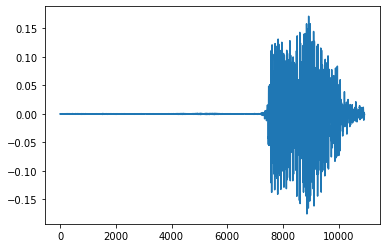

In [8]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[40]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [9]:
# Primer audio del set de entrenamiento. Dice "Marvin"
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [10]:
# Segundo audio del set de entrenamiento. Dice "Backward"
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [11]:
# Último audio del set de entrenamiento. Dice "Zero"
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [12]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

Al ser cargado el dataset con torchaudio.load, el waveform (Tensor) está normalizado entre [-1, 1]

In [13]:
print_stats(waveform, sample_rate)

Sample Rate: 16000
Shape: (1, 10922)
Dtype: torch.float32
 - Max:      0.171
 - Min:     -0.175
 - Mean:    -0.000
 - Std Dev:  0.031

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0003,  0.0004, -0.0006]])



Feature MFCC

In [14]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

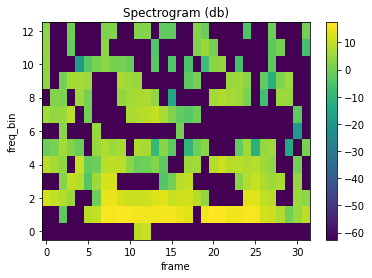

In [15]:
# MFCC de un audio en específico

waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]

n_mfcc = 13#256  #Number of mfc coefficients to retain
n_fft = 512#2048  #Size of FFT, creates n_fft//2 +1 bins
win_length = None #Window size (def = n_fft)
hop_length = 512#2048  #Length of hop between STFT windows (def = win_length//2)
n_mels = 13#256  #Number of mel filterbanks

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk"
    },
)

mfcc = mfcc_transform(waveform) #devuelve un Tensor, con dimensión 13x32

plot_spectrogram(mfcc[0])

In [16]:
mfcc.shape

torch.Size([1, 13, 32])

In [17]:
# MFCC de un set

def MFCC_set(audio_set):
  
  n_mfcc = 13#256  #Number of mfc coefficients to retain
  n_fft = 1024#2048  #Size of FFT, creates n_fft//2 +1 bins
  win_length = None #Window size (def = n_fft)
  hop_length = 1024#2048  #Length of hop between STFT windows (def = win_length//2)
  n_mels = 13#256  #Number of mel filterbanks

  out = []

  for audio in audio_set:
    waveform = audio[0]
    largo = waveform.shape[1]

    if largo != 16000:
      pad = (16000 - largo-1, 1)
      waveform = F.pad(waveform, pad, value=0)

    args={
          "n_fft": n_fft,
          "n_mels": n_mels,
          "hop_length": hop_length,
          "mel_scale": "htk",
    }

    mfcc_transform = T.MFCC(
      sample_rate=sample_rate,
      n_mfcc=n_mfcc,
      melkwargs=args
    )

    mfcc = mfcc_transform(waveform)
    out.append(mfcc[0].tolist())

  return torch.tensor(out)

In [18]:
X_train=MFCC_set(train_set)

In [19]:
X_train.shape

torch.Size([84843, 13, 16])

In [20]:
def clases_set(audio_set):
  out = []

  for audio in audio_set:
    command = audio[2]
    clase = labels.index(command)
    out.append(clase)

  return torch.tensor(out)

In [21]:
y_train=clases_set(train_set)

In [22]:
y_train.shape

torch.Size([84843])

In [23]:
print(len(X_train))
print(len(train_set))
print(len(y_train))
print(y_train[69420], train_set[69420][2])

84843
84843
84843
tensor(29) two


In [24]:
X_val = MFCC_set(val_set)
y_val = clases_set(val_set)

X_test = MFCC_set(test_set)
y_test = clases_set(test_set)

In [25]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

Feature Delta

In [26]:
# Delta de un audio en específico

# Se define la transformada delta
delta_transform = T.ComputeDeltas(win_length = 100)

waveform = train_set[41][0]
waveform2 = train_set[30][0]


delta = delta_transform(waveform)
delta2 = delta_transform(waveform2)

In [27]:
kk = torch.tensor(())
d = torch.cat((kk, delta2, delta), 0)
d.shape

torch.Size([2, 16000])

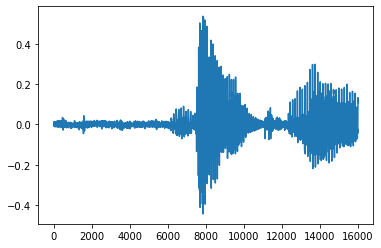

In [28]:
plt.plot(waveform.t().numpy());

In [29]:
# Delta de un audio en específico

def Delta_set(audio_set, win_length = 100):

  # Se define la transformada delta
  delta_transform = T.ComputeDeltas(win_length = 100)

  out = torch.tensor(())

  for audio in audio_set:
    waveform = audio[0]
    largo = waveform.shape[1]

    if largo != 16000:
      pad = (16000 - largo-1, 1)
      waveform = F.pad(waveform, pad, value=0)

    delta = delta_transform(waveform)
    out = torch.cat((out, delta), 0)

  return out

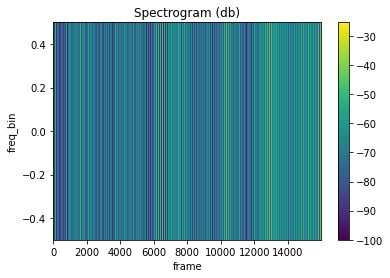

In [30]:
plot_spectrogram(delta)

Feature Delta-Delta

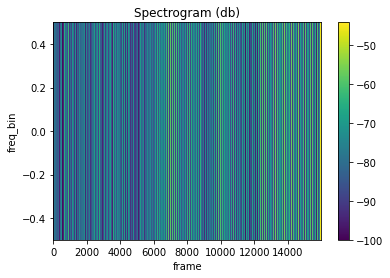

In [31]:
# Delta-Delta de un audio en específico

delta_delta = delta_transform(delta)
plot_spectrogram(delta_delta)

In [32]:
y_train[5000].shape

torch.Size([])

# Modelos

In [33]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [34]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, (h, c) = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [35]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

#Entrenamiento

In [36]:
def show_curves(all_curves):

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def get_metrics_and_confusion_matrix(model, dataset):
    model.cpu()
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=min(16, len(dataset)))
    y_true = []
    y_pred = []
    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, xticks_rotation="vertical")
    plt.show()

In [37]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count
                train_acc = cumulative_train_corrects / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.260534279705847, Train acc: 0.10718325791855203
Iteration 2174 - Batch 2174/6527 - Train loss: 3.0908433046012087, Train acc: 0.14072502210433244
Iteration 3261 - Batch 3261/6527 - Train loss: 2.9884392954980137, Train acc: 0.16268924208838373
Iteration 4348 - Batch 4348/6527 - Train loss: 2.9001831717808018, Train acc: 0.1830659568070467
Iteration 5435 - Batch 5435/6527 - Train loss: 2.821023651415851, Train acc: 0.20214241240731307
Iteration 6522 - Batch 6522/6527 - Train loss: 2.7481169365089437, Train acc: 0.2206158091486928
Val loss: 2.2905910732917873, Val acc: 0.3447550345656748
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.273058396051912, Train acc: 0.3427601809954751
Iteration 8701 - Batch 2174/6527 - Train loss: 2.244848723740413, Train acc: 0.352290008841733
Iteration 9788 - Batch 3261/6527 - Train loss: 2.2102932446504355, Train acc: 0.36334480969674104
Iteration 10875 - Batch 4348/6527 - Train 

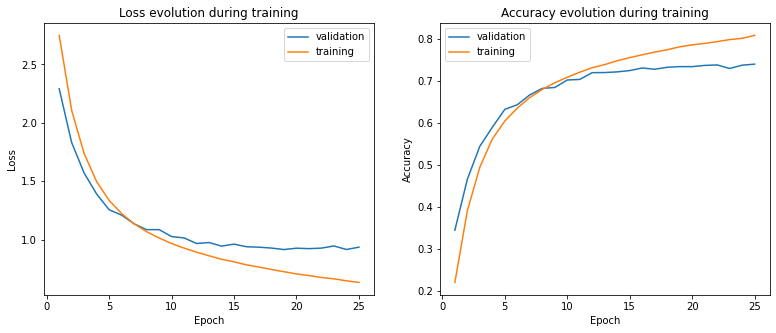

In [38]:
lr = 1e-4
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1

epochs = 25

all_curves = []
times = []

for train_run in range(n_trains):
    model1 = RNNModel(16)

    curves, total_time = train_model(
        model1,
        train_dataset,
        val_dataset,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.477241280105184, Train acc: 0.05571266968325792
Iteration 2174 - Batch 2174/6527 - Train loss: 3.3788461351942742, Train acc: 0.0758974358974359
Iteration 3261 - Batch 3261/6527 - Train loss: 3.2653139826712034, Train acc: 0.09960854596047729
Iteration 4348 - Batch 4348/6527 - Train loss: 3.144494649403998, Train acc: 0.12676654226435785
Iteration 5435 - Batch 5435/6527 - Train loss: 3.022390517660412, Train acc: 0.1563366728929643
Iteration 6522 - Batch 6522/6527 - Train loss: 2.9069729469569205, Train acc: 0.1835752780103539
Val loss: 2.173318571156245, Val acc: 0.369201482817353
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.1506961320033846, Train acc: 0.3767675339366516
Iteration 8701 - Batch 2174/6527 - Train loss: 2.084540825986314, Train acc: 0.39543766578249334
Iteration 9788 - Batch 3261/6527 - Train loss: 2.0145664169589557, Train acc: 0.4152478422864689
Iteration 10875 - Batch 4348/6527 - Train lo

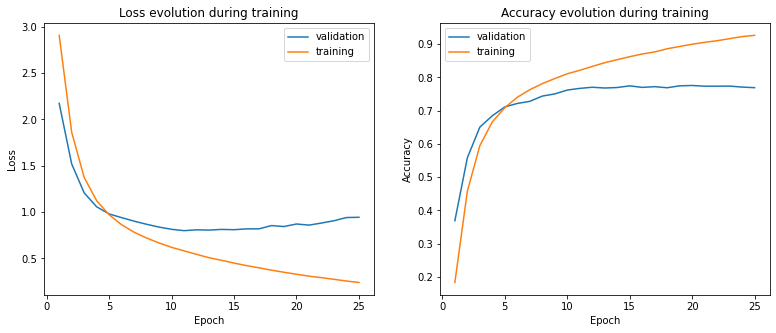

In [39]:
lr = 1e-4
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1

epochs = 25

all_curves = []
times = []

for train_run in range(n_trains):
    model2 = LSTMModel(16)

    curves, total_time = train_model(
        model2,
        train_dataset,
        val_dataset,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.4711672961711884, Train acc: 0.05847002262443439
Iteration 2174 - Batch 2174/6527 - Train loss: 3.37526790739476, Train acc: 0.07826702033598586
Iteration 3261 - Batch 3261/6527 - Train loss: 3.283150645723232, Train acc: 0.09567042399660425
Iteration 4348 - Batch 4348/6527 - Train loss: 3.1850247797019784, Train acc: 0.1166846489909263
Iteration 5435 - Batch 5435/6527 - Train loss: 3.085991548276983, Train acc: 0.13825210845078395
Iteration 6522 - Batch 6522/6527 - Train loss: 2.989023406794699, Train acc: 0.1601787756931096
Val loss: 2.3729687332748686, Val acc: 0.30007013325318105
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.333538906977457, Train acc: 0.3151866515837104
Iteration 8701 - Batch 2174/6527 - Train loss: 2.2697273445129396, Train acc: 0.3390981432360743
Iteration 9788 - Batch 3261/6527 - Train loss: 2.203016814646145, Train acc: 0.358958637928595
Iteration 10875 - Batch 4348/6527 - Train los

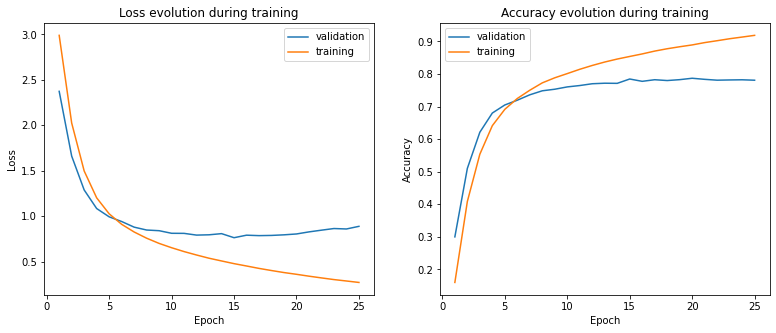

In [40]:
lr = 1e-4
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1

epochs = 25

all_curves = []
times = []

for train_run in range(n_trains):
    model = GRUModel(16)

    curves, total_time = train_model(
        model,
        train_dataset,
        val_dataset,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

# Métricas

In [41]:
val_probabilities = torch.reshape(model(X_val), (9981, 35)).tolist()

l = []
for fila in range(len(val_probabilities)):
  prob = -1e1000
  ind = 0
  for k in range(35):
    if val_probabilities[fila][k] > prob:
      prob = val_probabilities[fila][k]
      ind = k

  if prob == 1e-1000:
    print(fila)

  l.append(ind)

#l = (val_probabilities == val_probabilities.max()).tolist()
val_predicted_labels = torch.tensor(l)

In [42]:
j = torch.reshape(model(X_val), (9981, 35))

In [43]:
l = (j[0] == j[0].max()).tolist()
torch.tensor(l.index(True))

tensor(22)

In [44]:
y_val[10], val_predicted_labels[10]

(tensor(22), tensor(22))

Text(42.0, 0.5, 'True Label')

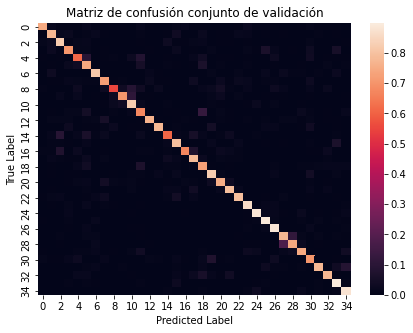

In [45]:
from sklearn.metrics import confusion_matrix

a= confusion_matrix(y_val, val_predicted_labels, normalize = 'true')
plt.figure(figsize=(7, 5))
plt.title("Matriz de confusión conjunto de validación")
b = sns.heatmap(a)
b.set_xlabel("Predicted Label")
b.set_ylabel("True Label")

In [46]:
val_probabilities = torch.reshape(model1(X_val), (9981, 35)).tolist()

l = []
for fila in range(len(val_probabilities)):
  prob = -1e1000
  ind = 0
  for k in range(35):
    if val_probabilities[fila][k] > prob:
      prob = val_probabilities[fila][k]
      ind = k

  if prob == 1e-1000:
    print(fila)

  l.append(ind)

#l = (val_probabilities == val_probabilities.max()).tolist()
val_predicted_labels = torch.tensor(l)

Text(42.0, 0.5, 'True Label')

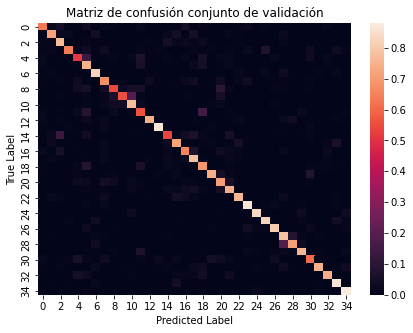

In [47]:
from sklearn.metrics import confusion_matrix

a= confusion_matrix(y_val, val_predicted_labels, normalize = 'true')
plt.figure(figsize=(7, 5))
plt.title("Matriz de confusión conjunto de validación")
#plt.xlabel("Predicted Label")
#plt.ylabel("True Label")
b = sns.heatmap(a)
b.set_xlabel("Predicted Label")
b.set_ylabel("True Label")

In [48]:
val_probabilities = torch.reshape(model2(X_val), (9981, 35)).tolist()

l = []
for fila in range(len(val_probabilities)):
  prob = -1e1000
  ind = 0
  for k in range(35):
    if val_probabilities[fila][k] > prob:
      prob = val_probabilities[fila][k]
      ind = k

  if prob == 1e-1000:
    print(fila)

  l.append(ind)

#l = (val_probabilities == val_probabilities.max()).tolist()
val_predicted_labels = torch.tensor(l)

Text(42.0, 0.5, 'True Label')

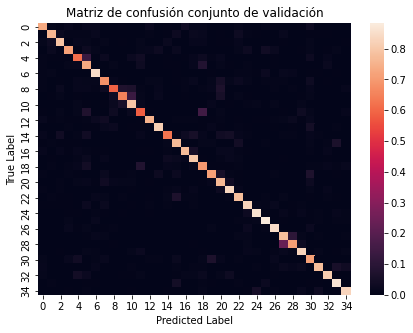

In [49]:
from sklearn.metrics import confusion_matrix

a= confusion_matrix(y_val, val_predicted_labels, normalize = 'true')
plt.figure(figsize=(7, 5))
plt.title("Matriz de confusión conjunto de validación")
b = sns.heatmap(a)
b.set_xlabel("Predicted Label")
b.set_ylabel("True Label")